In [11]:
# Load all depths and calculate mean metrics across all runs for each depth
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import numpy as np

results_dir = '../results_losses_circle'

# Define depths and loss types to analyze
depths = [1, 2, 3, 4, 5, 6, 7, 8]
loss_types = ["hilbert_schmidt", "pre_determine_inner", "log_likelihood_macro"]
depth_loss_results = {}

for depth in depths:
    depth_loss_results[depth] = {}
    
    for loss_type in loss_types:
        # Filter TQFM pickle files for this depth and loss type
        pattern = f'tqfm_{loss_type}_depth{depth}_'
        tqfm_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and pattern in f]
        
        if not tqfm_files:
            print(f"No files found for depth {depth}, loss {loss_type}")
            continue
        
        # Load all models for this depth and loss type
        models_data = []
        for tqfm_file in sorted(tqfm_files):
            try:
                with open(os.path.join(results_dir, tqfm_file), 'rb') as f:
                    tqfm = pickle.load(f)
                    
                    # Skip if best_params is None
                    if tqfm.best_params is None:
                        print(f"  Skipping {tqfm_file}: best_params is None")
                        continue
                    
                    final_loss = tqfm.loss_history[-1] if len(tqfm.loss_history) > 0 else None
                    train_acc = tqfm.train_accuracy_history[-1] if tqfm.train_accuracy_history else None
                    
                    if final_loss is not None and train_acc is not None:
                        models_data.append({
                            'tqfm': tqfm,
                            'file': tqfm_file,
                            'loss': final_loss,
                            'train_acc': train_acc
                        })
            except Exception as e:
                print(f"  Error loading {tqfm_file}: {e}")
        
        if models_data:
            # Calculate mean metrics across all valid runs
            mean_loss = np.mean([m['loss'] for m in models_data])
            std_loss = np.std([m['loss'] for m in models_data])
            mean_train_acc = np.mean([m['train_acc'] for m in models_data])
            std_train_acc = np.std([m['train_acc'] for m in models_data])
            
            depth_loss_results[depth][loss_type] = {
                'mean_loss': mean_loss,
                'std_loss': std_loss,
                'mean_train_acc': mean_train_acc,
                'std_train_acc': std_train_acc,
                'n_runs': len(models_data),
                'models': models_data
            }
            
            print(f"Depth {depth}, {loss_type}: {len(models_data)} valid runs")
            print(f"  Mean Loss: {mean_loss:.6f} ± {std_loss:.6f}")
            print(f"  Mean Train Acc: {mean_train_acc:.4f} ± {std_train_acc:.4f}")

print(f"\nTotal depths analyzed: {len(depth_loss_results)}")
print(f"Loss types: {loss_types}")

Depth 1, hilbert_schmidt: 20 valid runs
  Mean Loss: 0.769997 ± 0.031167
  Mean Train Acc: 1.0000 ± 0.0000
Depth 1, pre_determine_inner: 20 valid runs
  Mean Loss: 0.308988 ± 0.055864
  Mean Train Acc: 0.8510 ± 0.0924
Depth 1, log_likelihood_macro: 20 valid runs
  Mean Loss: 0.537019 ± 0.103558
  Mean Train Acc: 0.9300 ± 0.0884
Depth 2, hilbert_schmidt: 20 valid runs
  Mean Loss: 0.714668 ± 0.026172
  Mean Train Acc: 0.9990 ± 0.0030
Depth 2, pre_determine_inner: 20 valid runs
  Mean Loss: 0.256241 ± 0.034327
  Mean Train Acc: 0.9275 ± 0.0847
Depth 2, log_likelihood_macro: 20 valid runs
  Mean Loss: 0.335548 ± 0.065858
  Mean Train Acc: 0.9835 ± 0.0315
Depth 3, hilbert_schmidt: 20 valid runs
  Mean Loss: 0.703110 ± 0.024328
  Mean Train Acc: 0.9995 ± 0.0022
Depth 3, pre_determine_inner: 20 valid runs
  Mean Loss: 0.201293 ± 0.034654
  Mean Train Acc: 0.9670 ± 0.0531
Depth 3, log_likelihood_macro: 20 valid runs
  Mean Loss: 0.291187 ± 0.067654
  Mean Train Acc: 0.9785 ± 0.0263
Depth 4, h

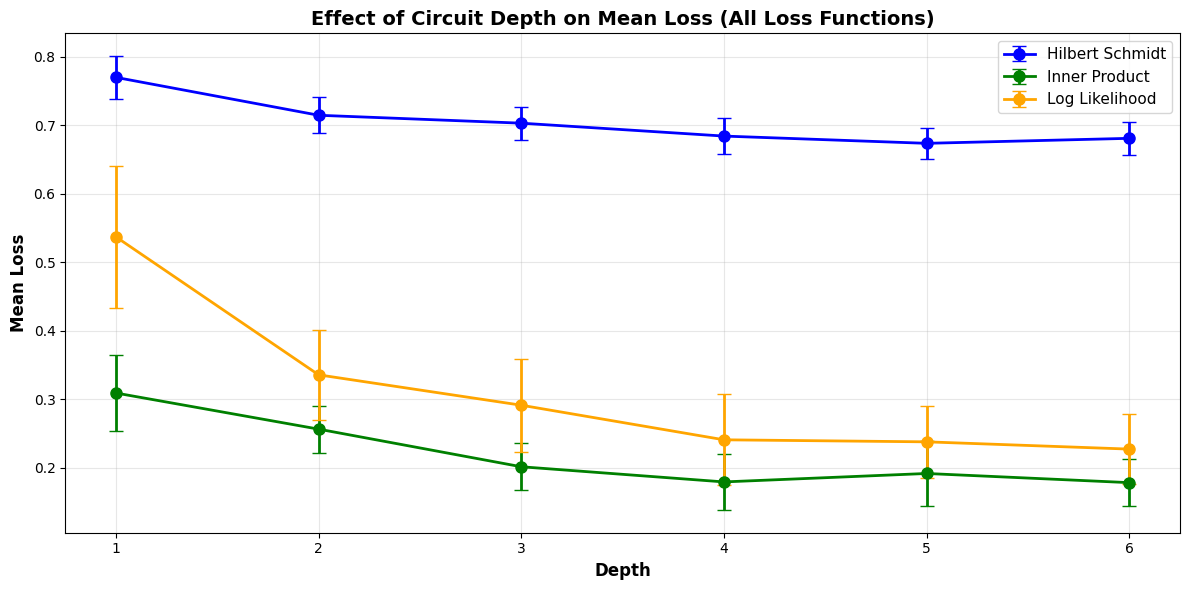

Mean Loss Summary:

HILBERT_SCHMIDT:
  Depth 1: 0.769997 ± 0.031167 (n=20)
  Depth 2: 0.714668 ± 0.026172 (n=20)
  Depth 3: 0.703110 ± 0.024328 (n=20)
  Depth 4: 0.684263 ± 0.026276 (n=20)
  Depth 5: 0.673665 ± 0.022405 (n=20)
  Depth 6: 0.680972 ± 0.024242 (n=20)

PRE_DETERMINE_INNER:
  Depth 1: 0.308988 ± 0.055864 (n=20)
  Depth 2: 0.256241 ± 0.034327 (n=20)
  Depth 3: 0.201293 ± 0.034654 (n=20)
  Depth 4: 0.179155 ± 0.041049 (n=20)
  Depth 5: 0.191477 ± 0.047601 (n=20)
  Depth 6: 0.178091 ± 0.034631 (n=20)

LOG_LIKELIHOOD_MACRO:
  Depth 1: 0.537019 ± 0.103558 (n=20)
  Depth 2: 0.335548 ± 0.065858 (n=20)
  Depth 3: 0.291187 ± 0.067654 (n=20)
  Depth 4: 0.240658 ± 0.066427 (n=20)
  Depth 5: 0.237692 ± 0.053007 (n=20)
  Depth 6: 0.227084 ± 0.050624 (n=20)


In [12]:
# Visualize Mean Loss vs Depth for all loss types
import matplotlib.pyplot as plt
import numpy as np

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

colors = {'hilbert_schmidt': 'blue', 'pre_determine_inner': 'green', 'log_likelihood_macro': 'orange'}
labels = {'hilbert_schmidt': 'Hilbert Schmidt', 'pre_determine_inner': 'Inner Product', 'log_likelihood_macro': 'Log Likelihood'}

for loss_type in loss_types:
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        plt.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5, 
                    label=labels[loss_type],
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Loss', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Loss (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.tight_layout()
plt.show()

print("Mean Loss Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_loss']:.6f} ± {result['std_loss']:.6f} (n={result['n_runs']})")

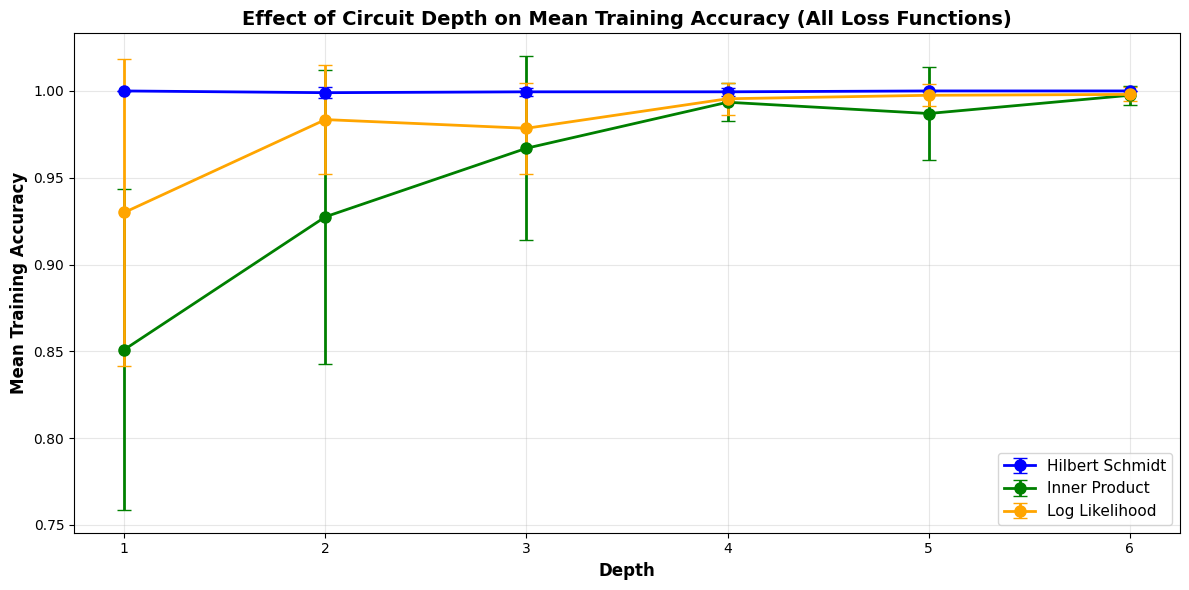


Mean Training Accuracy Summary:

HILBERT_SCHMIDT:
  Depth 1: 1.0000 ± 0.0000 (n=20)
  Depth 2: 0.9990 ± 0.0030 (n=20)
  Depth 3: 0.9995 ± 0.0022 (n=20)
  Depth 4: 0.9995 ± 0.0022 (n=20)
  Depth 5: 1.0000 ± 0.0000 (n=20)
  Depth 6: 1.0000 ± 0.0000 (n=20)

PRE_DETERMINE_INNER:
  Depth 1: 0.8510 ± 0.0924 (n=20)
  Depth 2: 0.9275 ± 0.0847 (n=20)
  Depth 3: 0.9670 ± 0.0531 (n=20)
  Depth 4: 0.9935 ± 0.0111 (n=20)
  Depth 5: 0.9870 ± 0.0269 (n=20)
  Depth 6: 0.9975 ± 0.0054 (n=20)

LOG_LIKELIHOOD_MACRO:
  Depth 1: 0.9300 ± 0.0884 (n=20)
  Depth 2: 0.9835 ± 0.0315 (n=20)
  Depth 3: 0.9785 ± 0.0263 (n=20)
  Depth 4: 0.9955 ± 0.0092 (n=20)
  Depth 5: 0.9975 ± 0.0062 (n=20)
  Depth 6: 0.9980 ± 0.0040 (n=20)


In [13]:
# Visualize Mean Training Accuracy vs Depth for all loss types
depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

colors = {'hilbert_schmidt': 'blue', 'pre_determine_inner': 'green', 'log_likelihood_macro': 'orange'}
labels = {'hilbert_schmidt': 'Hilbert Schmidt', 'pre_determine_inner': 'Inner Product', 'log_likelihood_macro': 'Log Likelihood'}

for loss_type in loss_types:
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        plt.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5,
                    label=labels[loss_type],
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Training Accuracy (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.tight_layout()
plt.show()

print("\nMean Training Accuracy Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_train_acc']:.4f} ± {result['std_train_acc']:.4f} (n={result['n_runs']})")

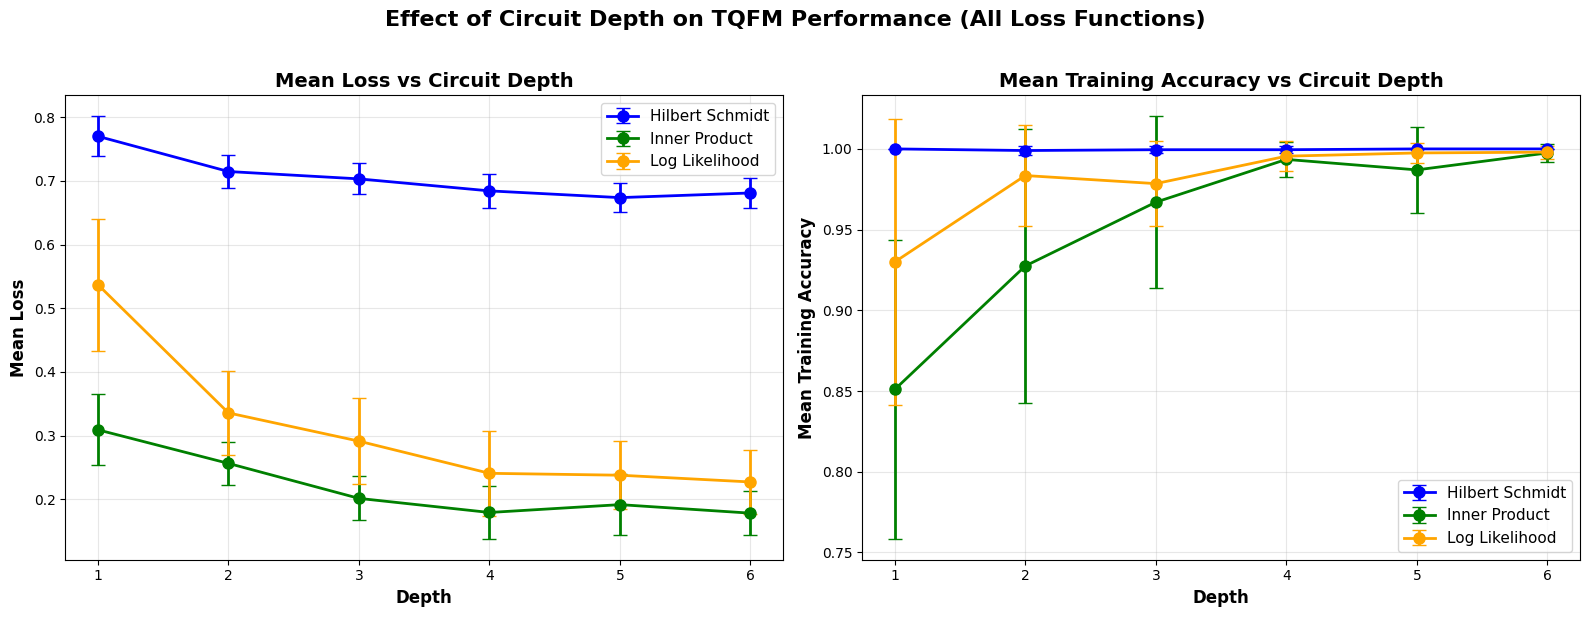

In [14]:
# Combined visualization: Mean Loss and Mean Accuracy for all loss types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])
colors = {'hilbert_schmidt': 'blue', 'pre_determine_inner': 'green', 'log_likelihood_macro': 'orange'}
labels = {'hilbert_schmidt': 'Hilbert Schmidt', 'pre_determine_inner': 'Inner Product', 'log_likelihood_macro': 'Log Likelihood'}


# Left plot: Mean Loss vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        ax1.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=labels[loss_type],
                    color=colors[loss_type])

ax1.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Loss', fontsize=12, fontweight='bold')
ax1.set_title('Mean Loss vs Circuit Depth', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)

# Right plot: Mean Training Accuracy vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        ax2.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=labels[loss_type],
                    color=colors[loss_type])

ax2.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Mean Training Accuracy vs Circuit Depth', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)

plt.suptitle('Effect of Circuit Depth on TQFM Performance (All Loss Functions)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Depth 1, Hilbert Schmidt: 20 runs
  Mean Time: 184.19s ± 41.29s (3.07 min)
Depth 1, Inner Product: 20 runs
  Mean Time: 117.12s ± 59.54s (1.95 min)
Depth 1, Log Likelihood: 20 runs
  Mean Time: 154.86s ± 55.20s (2.58 min)
Depth 2, Hilbert Schmidt: 20 runs
  Mean Time: 296.27s ± 62.49s (4.94 min)
Depth 2, Inner Product: 20 runs
  Mean Time: 284.37s ± 72.24s (4.74 min)
Depth 2, Log Likelihood: 20 runs
  Mean Time: 279.75s ± 78.82s (4.66 min)
Depth 3, Hilbert Schmidt: 20 runs
  Mean Time: 364.92s ± 81.64s (6.08 min)
Depth 3, Inner Product: 20 runs
  Mean Time: 367.17s ± 82.11s (6.12 min)
Depth 3, Log Likelihood: 20 runs
  Mean Time: 364.56s ± 92.10s (6.08 min)
Depth 4, Hilbert Schmidt: 20 runs
  Mean Time: 404.52s ± 10.07s (6.74 min)
Depth 4, Inner Product: 20 runs
  Mean Time: 407.71s ± 11.65s (6.80 min)
Depth 4, Log Likelihood: 20 runs
  Mean Time: 411.95s ± 13.62s (6.87 min)
Depth 5, Hilbert Schmidt: 20 runs
  Mean Time: 494.50s ± 124.54s (8.24 min)
Depth 5, Inner Product: 20 runs
  Me

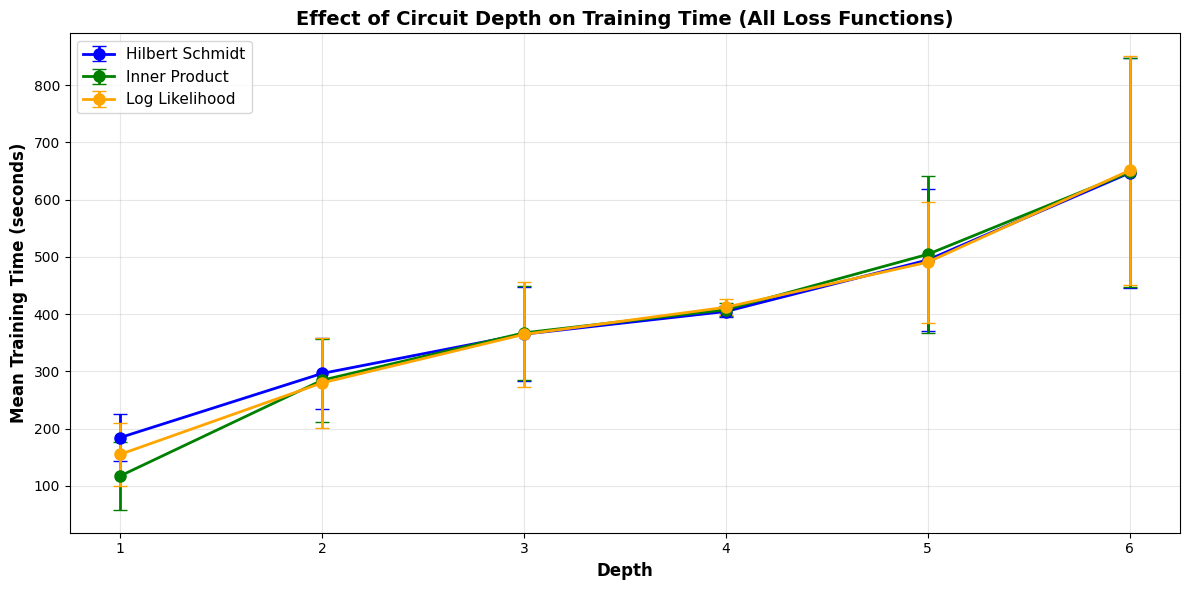


TRAINING TIME SUMMARY (seconds)
Depth   Hilbert Schmidt          Inner Product            Log Likelihood           
--------------------------------------------------------------------------------
1       184.2 ± 41.3             117.1 ± 59.5             154.9 ± 55.2             
2       296.3 ± 62.5             284.4 ± 72.2             279.8 ± 78.8             
3       364.9 ± 81.6             367.2 ± 82.1             364.6 ± 92.1             
4       404.5 ± 10.1             407.7 ± 11.7             411.9 ± 13.6             
5       494.5 ± 124.5            504.4 ± 137.3            490.7 ± 105.8            
6       646.6 ± 201.3            647.7 ± 200.5            651.0 ± 200.0            


In [17]:
# Analyze Training Time for all loss types across depths
import json
import glob

results_dir = '../results_losses_circle'
depths = [1, 2, 3, 4, 5, 6]
loss_types = ["hilbert_schmidt", "pre_determine_inner", "log_likelihood_macro"]
labels = {'hilbert_schmidt': 'Hilbert Schmidt', 'pre_determine_inner': 'Inner Product', 'log_likelihood_macro': 'Log Likelihood'}
colors = {'hilbert_schmidt': 'blue', 'pre_determine_inner': 'green', 'log_likelihood_macro': 'orange'}

# Collect training times
depth_time_results = {}

for depth in depths:
    depth_time_results[depth] = {}
    
    # Find all training_times JSON files for this depth
    pattern = f'{results_dir}/training_times_depth{depth}_*.json'
    time_files = glob.glob(pattern)
    
    if not time_files:
        print(f"No training time files found for depth {depth}")
        continue
    
    # Collect times for each loss type
    times_by_loss = {loss: [] for loss in loss_types}
    
    for time_file in time_files:
        try:
            with open(time_file, 'r') as f:
                data = json.load(f)
                individual_times = data.get('individual_training_times', {})
                
                for loss_type in loss_types:
                    if loss_type in individual_times:
                        times_by_loss[loss_type].append(individual_times[loss_type])
        except Exception as e:
            print(f"  Error loading {time_file}: {e}")
    
    # Calculate mean and std for each loss type
    for loss_type in loss_types:
        if times_by_loss[loss_type]:
            mean_time = np.mean(times_by_loss[loss_type])
            std_time = np.std(times_by_loss[loss_type])
            depth_time_results[depth][loss_type] = {
                'mean_time': mean_time,
                'std_time': std_time,
                'n_runs': len(times_by_loss[loss_type]),
                'all_times': times_by_loss[loss_type]
            }
            print(f"Depth {depth}, {labels[loss_type]}: {len(times_by_loss[loss_type])} runs")
            print(f"  Mean Time: {mean_time:.2f}s ± {std_time:.2f}s ({mean_time/60:.2f} min)")

# Visualize Training Time vs Depth
plt.figure(figsize=(12, 6))

for loss_type in loss_types:
    times = []
    stds = []
    valid_depths = []
    
    for d in depths:
        if d in depth_time_results and loss_type in depth_time_results[d]:
            times.append(depth_time_results[d][loss_type]['mean_time'])
            stds.append(depth_time_results[d][loss_type]['std_time'])
            valid_depths.append(d)
    
    if times:
        plt.errorbar(valid_depths, times, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5, 
                    label=labels[loss_type],
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Training Time (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("TRAINING TIME SUMMARY (seconds)")
print("="*80)
print(f"{'Depth':<8}", end="")
for loss_type in loss_types:
    print(f"{labels[loss_type]:<25}", end="")
print()
print("-"*80)

for d in depths:
    print(f"{d:<8}", end="")
    for loss_type in loss_types:
        if d in depth_time_results and loss_type in depth_time_results[d]:
            result = depth_time_results[d][loss_type]
            print(f"{result['mean_time']:.1f} ± {result['std_time']:.1f}".ljust(25), end="")
        else:
            print("N/A".ljust(25), end="")
    print()
print("="*80)